In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math
import numpy as np

Building model using tf.keras and hub. from sentences to embeddings.

Inputs:

 - input token ids (tokenizer converts tokens using vocab file)
 - input masks (1 for useful tokens, 0 for padding)
 - segment ids (for 2 text training: 0 for the first one, 1 for the second one)

Outputs:

 - pooled_output of shape [batch_size, 768] with representations for the entire input sequences
 - sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context)

In [2]:
max_seq_length = 256  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [3]:
[input_word_ids, input_mask, segment_ids]

[<tf.Tensor 'input_word_ids:0' shape=(None, 256) dtype=int32>,
 <tf.Tensor 'input_mask:0' shape=(None, 256) dtype=int32>,
 <tf.Tensor 'segment_ids:0' shape=(None, 256) dtype=int32>]

In [4]:
[pooled_output, sequence_output]

[<tf.Tensor 'keras_layer/Identity:0' shape=(None, 768) dtype=float32>,
 <tf.Tensor 'keras_layer/Identity_1:0' shape=(None, None, 768) dtype=float32>]

In [5]:
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

Generating segments and masks based on the original BERT

In [7]:
# See BERT paper: https://arxiv.org/pdf/1810.04805.pdf
# And BERT implementation convert_single_example() at https://github.com/google-research/bert/blob/master/run_classifier.py

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

Import tokenizer using the original vocab file

In [8]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

# Test BERT embedding generator model

In [9]:
s = "This is a nice sentence."

# tokenize sentence
stokens = tokenizer.tokenize(s)

# Add serparator tokens
stokens = ["[CLS]"] + stokens + ["[SEP]"]

# get model inputs from tokens
input_ids = get_ids(stokens, tokenizer, max_seq_length)
input_masks = get_masks(stokens, max_seq_length)
input_segments = get_segments(stokens, max_seq_length)

print(stokens)
print(input_ids)
print(input_masks)
print(input_segments)

print(tf.shape(stokens))
print(tf.shape(input_ids))
print(tf.shape(input_masks))
print(tf.shape(input_segments))

#inputs = [[[input_ids]], [[input_masks]], [[input_segments]]]
inputs = [np.array([input_ids]), np.array([input_masks]), np.array([input_segments])]
print(inputs)

# generate embeddings
pool_embs, all_embs = model.predict(inputs)

['[CLS]', 'this', 'is', 'a', 'nice', 'sentence', '.', '[SEP]']
[101, 2023, 2003, 1037, 3835, 6251, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [10]:
print(np.shape(np.squeeze(all_embs)))

(256, 768)


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

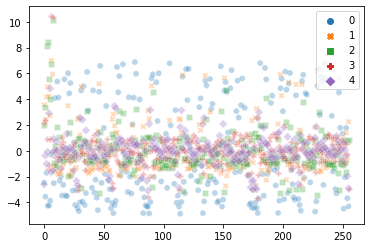

In [29]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(np.squeeze(all_embs))
#print(pca_result)
#plt.plot(pca_result, '*')
sns.scatterplot(
    #x="pca-one", y="pca-two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=pca_result,
    legend="full",
    alpha=0.3
)

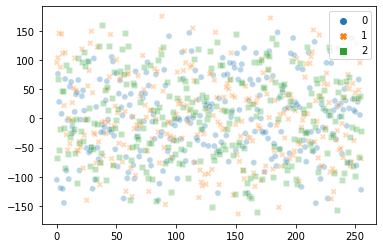

In [45]:
tsne = TSNE(n_components=3, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.squeeze(all_embs))
tsne_results.shape

sns.scatterplot(
    #x="pca-one", y="pca-two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=X_embedded,
    legend="full",
    alpha=0.3
)

# Pooled embedding vs [CLS] as sentence-level representation

Previously, the [CLS] token's embedding were used as sentence-level representation (see the original paper). However, here a pooled embedding were introduced. This part is a short comparison of the two embedding using cosine similarity

In [12]:
def square_rooted(x):
    return math.sqrt(sum([a*a for a in x]))


def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return numerator/float(denominator)

In [13]:
cosine_similarity(pool_embs[0], all_embs[0][0])

0.027572655361745843